In [ ]:
import cv2
import numpy as np
import torch
import torchvision
from kan import KAN
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('dark_background')
train_data = torchvision.datasets.MNIST(root="./mnist_data", train=True, download=True, transform=None)
test_data = torchvision.datasets.MNIST(root="./mnist_data", train=False, download=True, transform=None)

In [ ]:
def preprocess_data(data):
    images = []
    labels = []
    for img, label in data:
        img = np.array(img)
        img = cv2.resize(img, (7, 7))
        img = img.flatten() / 255.0
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = preprocess_data(train_data)
test_images, test_labels = preprocess_data(test_data)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")

In [ ]:
dataset = {
    "train_input": torch.from_numpy(train_images).float().to(device),
    "train_label": torch.from_numpy(train_labels).long().to(device),
    "test_input": torch.from_numpy(test_images).float().to("cpu"),
    "test_label": torch.from_numpy(test_labels).long().to("cpu"),
}

In [50]:
def create_kan():
    return KAN(width=[7**2, 10, 10], grid=4, k=2)
model = create_kan()

In [51]:
def test_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["test_input"]), dim=1)
        correct = (predictions == dataset["test_label"]).float()
        accuracy = correct.mean()
    return accuracy

def train_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["train_input"].to('cpu')), dim=1)
        correct = (predictions == dataset["train_label"].to('cpu')).float()
        accuracy = correct.mean()
    return accuracy

# Train the model
results = model.train(
    dataset,
    opt="LBFGS",
    steps=25,
    batch=512,
    loss_fn=torch.nn.CrossEntropyLoss(),
    metrics=(train_acc, test_acc),
)

train loss: 1.16e+00 | test loss: 1.21e+00 | reg: 1.75e+02 : 100%|██| 25/25 [05:04<00:00, 12.18s/it]


In [52]:
torch.save(model.state_dict(), "kan.pth")

Test accuracy: 42.20%
total number of parameters: 8691


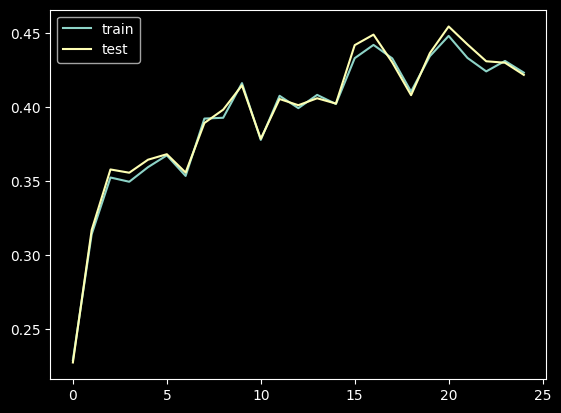

In [53]:
del model
model = create_kan()
model.load_state_dict(torch.load("kan.pth"))

acc = test_acc()
print(f"Test accuracy: {acc.item() * 100:.2f}%")
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params}")

plt.plot(results["train_acc"], label="train")
plt.plot(results["test_acc"], label="test")
plt.legend()

## MLP Version

Now let's implement the *FullyConnected* MLP version  

In [ ]:
import torch.nn as nn
import torch.optim as optim

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(7*7, 128)  # 7*7 is the size of the resized and flattened image
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Output 10 classes for MNIST digits

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:

train_images, train_labels = preprocess_data(train_data)
test_images, test_labels = preprocess_data(test_data)

train_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

15306
Train Accuracy: 90.61%
Test Accuracy: 91.38%


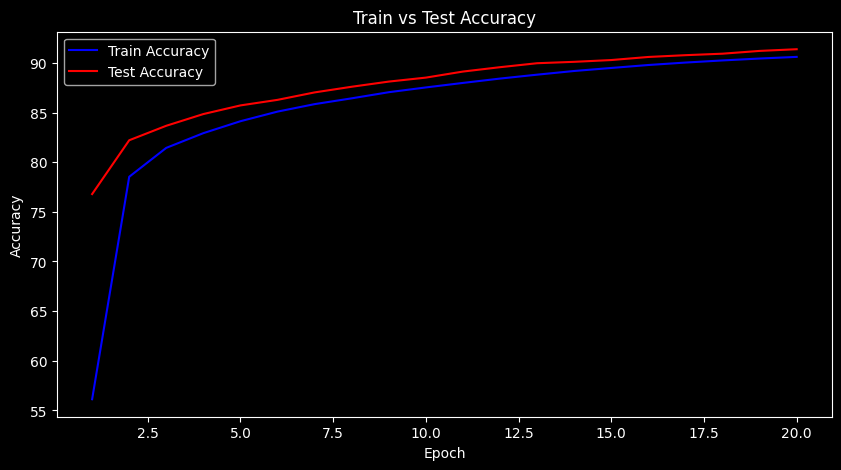

In [25]:

def train_and_evaluate(model, train_data, train_labels, test_data, test_labels, epochs=20, batch_size=512):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train = 0
        correct_train = 0

        for i in range(0, len(train_data), batch_size):
            inputs = train_data[i:i+batch_size].to(device)
            labels = train_labels[i:i+batch_size].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy within the epoch
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        test_accuracy = evaluate_accuracy(model, test_data, test_labels, batch_size)
        test_accuracies.append(test_accuracy)
        
        if epoch == epochs-1:
            print(f'Train Accuracy: {train_accuracy:.2f}%')
            print(f'Test Accuracy: {test_accuracy:.2f}%')

    # Plot accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(range(1, epochs+1), test_accuracies, 'r-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.show()

def evaluate_accuracy(model, data, labels, batch_size):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            inputs = data[i:i+batch_size].to(device)
            target = labels[i:i+batch_size].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# Assuming device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FullyConnectedNN().to(device)

# Print the number of parameters
print(sum(p.numel() for p in model.parameters()))

# Call the training function
train_and_evaluate(model, train_tensor, train_labels_tensor, test_tensor, test_labels_tensor)